In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve, windows

In [4]:
# generate spike trains that slowly increase in rate

# 30 minutes of data
# from 1 Hz to 10 Hz
# add sinusoidal noises

def gen_spike():
    np.random.seed(0)
    sample_rate = 25000
    n_time = 30
    times = np.arange(n_time)

    rates = np.linspace(1, 10, n_time) + 0.5 * np.sin(2 * np.pi * 0.05 * times) + 2*np.random.normal(0, 0.5, n_time)
    rates = np.repeat(rates, sample_rate * 60)
    spikes = np.random.poisson(rates / sample_rate)

    spk = np.where(spikes)[0] / sample_rate
    return spk

spk = gen_spike()

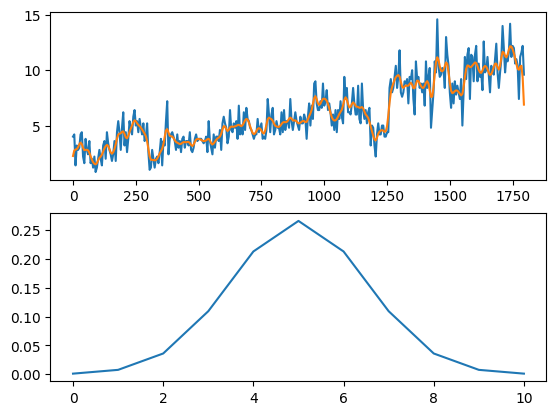

In [37]:
time_bin = np.arange(0, 1805, 5)
spk_bin, _ = np.histogram(spk, time_bin)
fr_bin = spk_bin / 5

window = windows.gaussian(11, std=1.5)
window /= window.sum()
fr_conv = convolve(fr_bin, window, mode='same')

plt.subplot(211)
plt.plot(time_bin[:-1], fr_bin)
plt.plot(time_bin[:-1], fr_conv)
plt.subplot(212)
plt.plot(window)

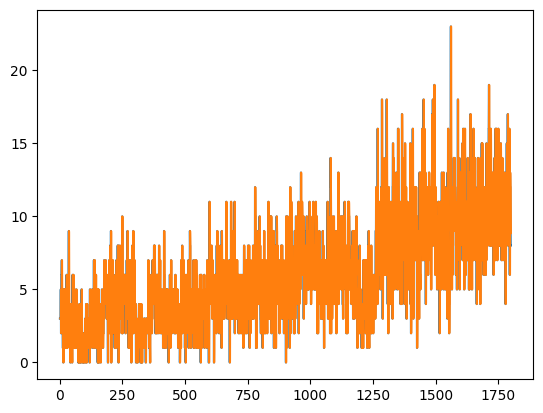

In [6]:
kkmonitor_duration = 1800 # seconds
window_size = 60 # seconds
window_step = 0.1 # seconds
n_window = 10

time_end = spk[-1]
time_start = max(spk[0], time_end - monitor_duration)
time_bin = np.arange(time_end, time_start, -window_step)[::-1]

conv_win = np.ones(n_window)

spk_bin, _ = np.histogram(spk.astype(int), time_bin)
spk_bin = np.convolve(spk_bin, conv_win, mode='valid')
# match the length of time_bin with spk_bin
n_spk_bin = len(spk_bin)
time_bin = time_bin[-n_spk_bin:]


gaussian_win = windows.gaussian(20, std=1)
gaussian_win /= gaussian_win.sum()
spk_cov = convolve(spk_bin, gaussian_win, mode='valid')
time_conv = time_bin[-len(spk_cov):]

plt.plot(time_bin, spk_bin)
plt.plot(time_conv, spk_cov)

In [9]:
spk_bin, _ = np.histogram(spk.astype(int), time_bin)
spk_bin.sum()

10926

In [17]:
fire_rate = 1/3 # Hz
n_step = int(window_size//window_step)
n_fire = int(window_size * fire_rate)

tresholds = []
# for i in range(1):
# Vectorize operations and avoid repeated calculations

X = spk_bin[:600]

def transform(X, target=12, B_bins=10):
    X_conv = np.convolve(X, np.ones(B_bins), mode='valid')
    left, right = 1, X_conv.max() + 1
    
    while left < right:
        threshold = (left + right) // 2
        over_threshold = X_conv >= threshold
        
        # Find transitions using boolean operations
        transitions = over_threshold[1:] != over_threshold[:-1]
        block_start = np.where(~over_threshold[:-1] & transitions)[0]
        block_end = np.where(over_threshold[:-1] & transitions)[0]
        
        if len(block_start) == 0 or len(block_end) == 0:
            right = threshold
            continue
            
        fire_count = np.ceil((block_end - block_start) / B_bins).sum()
        
        if fire_count >= target:
            left = threshold + 1
        else:
            right = threshold
    
    return left - 1

import time
start = time.time()
for _ in range(10000):
    thres = transform(X)
end = time.time()
print((end - start)/10000)
thres

3.643786907196045e-05


5.0

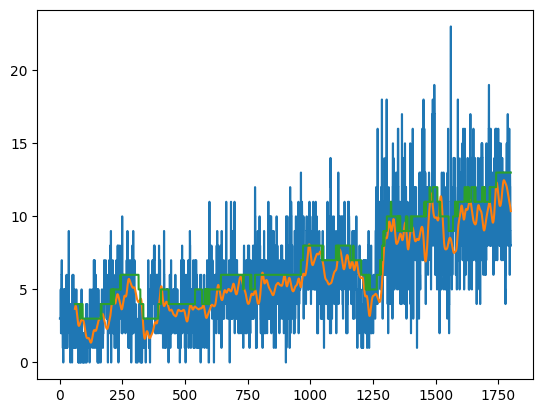

In [54]:
time_threshold = time_bin[-len(tresholds):]
plt.plot(time_bin, spk_bin)
plt.plot(time_conv, spk_cov)
plt.plot(time_threshold, tresholds)

In [26]:
spk[-1], time_bin[-1]

(1799.82372, 1800.10844)